In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
import math
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from functions import feature_extraction
import warnings
# from pandas.core.common import SettingWithCopyWarning

# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


2023-06-01 15:43:02.619011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
AEP = pd.read_csv('AEP_hourly.csv')
AEP = AEP.rename(columns={'AEP_MW': 'Load'})
features, data = feature_extraction(AEP, diff_in_hour=1, num_days_ago=21, num_hours_forecasting=24,  test_split = 0.1, validation_split = 0.2)

/Users/eliorsegev/Library/Mobile Documents/com~apple~CloudDocs/Studying/Uni/Master/papers/Ram/functions.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{i * diff_in_hour}_hrs_ago'] = df['Load'].shift(i)
/Users/eliorsegev/Library/Mobile Documents/com~apple~CloudDocs/Studying/Uni/Master/papers/Ram/functions.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{i * diff_in_hour}_hrs_ago'] = df['Load'].shift(i)
/Users/eliorsegev/Library/Mobile Documents/com~apple~CloudDocs/Studying/Uni/Master/papers/Ram/functions.py:5

/Users/eliorsegev/Library/Mobile Documents/com~apple~CloudDocs/Studying/Uni/Master/papers/Ram/functions.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{i * diff_in_hour}_hrs_ago'] = df['Load'].shift(i)
/Users/eliorsegev/Library/Mobile Documents/com~apple~CloudDocs/Studying/Uni/Master/papers/Ram/functions.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{i * diff_in_hour}_hrs_ago'] = df['Load'].shift(i)
/Users/eliorsegev/Library/Mobile Documents/com~apple~CloudDocs/Studying/Uni/Master/papers/Ram/functions.py:5

/Users/eliorsegev/Library/Mobile Documents/com~apple~CloudDocs/Studying/Uni/Master/papers/Ram/functions.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{i * diff_in_hour}_hrs_ago'] = df['Load'].shift(i)
/Users/eliorsegev/Library/Mobile Documents/com~apple~CloudDocs/Studying/Uni/Master/papers/Ram/functions.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{i * diff_in_hour}_hrs_ago'] = df['Load'].shift(i)
/Users/eliorsegev/Library/Mobile Documents/com~apple~CloudDocs/Studying/Uni/Master/papers/Ram/functions.py:5

In [5]:
 AEP

,Datetime,Load
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [6]:
x_train = np.concatenate((data['x_train_seq'],data['x_train_dt']), axis=1)
y_train = data['y_train']
x_val = np.concatenate((data['x_val_seq'],data['x_val_dt']), axis=1)
y_val = data['y_val']
x_test = np.concatenate((data['x_test_seq'],data['x_test_dt']), axis=1)
y_test = data['y_test']

In [ ]:
print(x_train.shape)

In [ ]:
[int(512/2**(i*1)) for i in range(1,13)]

This is a NN model:

In [7]:
input_layer = Input(shape=(x_train.shape[1]))

dense = Dense(512, activation='relu')(input_layer)
layers = [int(512/2**(i*0.2)) for i in range(1,4)]

for l in layers:
    dense = Dense(l, activation='relu')(dense)
#     dense = Dropout(0.05)(dense)
    
output_layer = Dense(24)(dense)

model_NN = Model(inputs = input_layer, outputs= output_layer)

model_NN.compile(optimizer='adam', loss='mse', metrics=['mae'])
# model_NN.summary()
history_NN = model_NN.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

2023-05-30 13:31:06.672289: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
2638/2638 [==============================] - 12s 4ms/step - loss: 1.6311 - mae: 0.4560 - val_loss: 0.2740 - val_mae: 0.4062
Epoch 2/10
2638/2638 [==============================] - 11s 4ms/step - loss: 0.1552 - mae: 0.2999 - val_loss: 0.1640 - val_mae: 0.3061
Epoch 3/10
2638/2638 [==============================] - 12s 4ms/step - loss: 0.1378 - mae: 0.2821 - val_loss: 0.1691 - val_mae: 0.3135
Epoch 4/10
2638/2638 [==============================] - 12s 5ms/step - loss: 0.1233 - mae: 0.2652 - val_loss: 0.1310 - val_mae: 0.2670
Epoch 5/10
2638/2638 [==============================] - 13s 5ms/step - loss: 0.1088 - mae: 0.2472 - val_loss: 0.1179 - val_mae: 0.2493
Epoch 6/10
2638/2638 [==============================] - 14s 5ms/step - loss: 0.1034 - mae: 0.2402 - val_loss: 0.1350 - val_mae: 0.2799
Epoch 7/10
2638/2638 [==============================] - 13s 5ms/step - loss: 0.0969 - mae: 0.2320 - val_loss: 0.1122 - val_mae: 0.2430
Epoch 8/10
2638/2638 [==============================] -

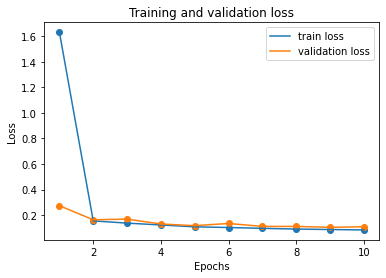

In [8]:
plt.plot(range(1,len(history_NN.history['loss'])+1),history_NN.history['loss'], label='train loss')
plt.plot(range(1,len(history_NN.history['val_loss'])+1), history_NN.history['val_loss'], label='validation loss')
plt.scatter(range(1, len(history_NN.history['loss'])+1),history_NN.history['loss'])
plt.scatter(range(1, len(history_NN.history['val_loss'])+1), history_NN.history['val_loss'])
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# model_layers =  model_NN.layers
# print(model_layers[-1].get_weights())
x_train.shape
y_train.shape

In [9]:
y_hat = np.array(model_NN.predict(x_val))
y_hat = y_hat*data['std_value_load'] + data['mean_value_load']
y = y_val*data['std_value_load'] + data['mean_value_load']

758/758 [==============================] - 1s 2ms/step


y mean: -0.003293549846654527, y std: 1.0003404755560785
y_hat mean: 15037.1650390625, y_hat std: 2536.003662109375


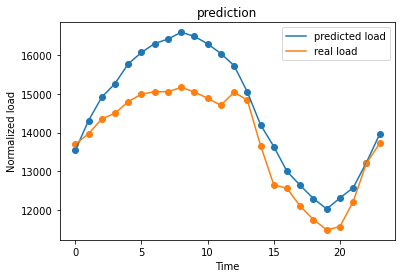

In [14]:
index = 8000

print(f'y mean: {y_train.mean()}, y std: {y_train.std()}')
print(f'y_hat mean: {y_hat.mean()}, y_hat std: {y_hat.std()}')

y_plot_hat = y_hat[index,:]
y_plot = y[index,:]

plt.plot(range(len(y_plot_hat)), y_plot_hat, label='predicted load')
plt.plot(range(len(y_plot)), y_plot, label='real load')
plt.scatter(range(len(y_plot_hat)), y_plot_hat)
plt.scatter(range(len(y_plot)), y_plot)
plt.title('prediction')
plt.xlabel('Time')
plt.ylabel('Normalized load')
plt.legend()
plt.show()

In [ ]:
# an LSTM Model:

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(12, activation='relu', input_shape=(x_train.shape[1], 1)))
model_LSTM.add(RepeatVector(y_train.shape[1]))
model_LSTM.add(LSTM(12, activation='relu', return_sequences=True))
model_LSTM.add(TimeDistributed(Dense(1)))
model_LSTM.summary()
model_LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])
history_LSTM = model_LSTM.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

In [ ]:
history_LSTM2 = model_LSTM.fit(x_train, y_train, epochs=1, validation_data=(x_val, y_val))

In [ ]:
# history_LSTM
for i in range(2,9):
    model_LSTM = tf.keras.Sequential()
    model_LSTM.add(LSTM(64, dropout=0.1*i, recurrent_dropout=0.1*i, activation='relu', input_shape=(x_train.shape[1], 1)))
    model_LSTM.add(Dense(32))
    model_LSTM.add(Dense(16))
    model_LSTM.add(Dense(8))
    model_LSTM.add(Dense(4))
    model_LSTM.add(Dense(1))

    optimizer = Adam(clipvalue=1.0)

    model_LSTM.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    history_LSTM = model_LSTM.fit(x_train, y_train, epochs=1, verbose=1, validation_data=(x_val, y_val))
    plt.plot(range(1, len(history_LSTM.history['loss'])+1),history_LSTM.history['loss'], label='train loss i')
    plt.scatter(range(1, len(history_LSTM.history['loss'])+1),history_LSTM.history['loss'])
    plt.show()


In [ ]:
epochs = 1
if 'history_LSTM' in globals():
    history_LSTM_cont = model_LSTM.fit(x_train, y_train, epochs=epochs, verbose=1, validation_data=(x_val, y_val))
    for key in history_LSTM.history.keys():
        history_LSTM.history[key] += history_LSTM_cont.history[key]

else:
    history_LSTM = model_LSTM.fit(x_train, y_train, epochs=epochs, verbose=1, validation_data=(x_val, y_val))

In [ ]:
plt.plot(range(1, len(history_LSTM.history['loss'])+1),history_LSTM.history['loss'], label='train loss')
plt.plot(range(1, len(history_LSTM.history['val_loss'])+1), history_LSTM.history['val_loss'], label='validation loss')
plt.scatter(range(1, len(history_LSTM.history['loss'])+1),history_LSTM.history['loss'])
plt.scatter(range(1, len(history_LSTM.history['val_loss'])+1), history_LSTM.history['val_loss'])
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()